# Evaluation of SFINCS vs HAND-FIM
### Author: Tadd Bindas

The following notebook is comparing the outputs of SFINCS with the outputs of:
1. HAND
- Generated from FIM-C PI3 TP1 Subcase 2
- The command to rerun this is: `python retro_flows.py --fim-version PI3_fim60_10m_wbt --huc 11070103 --date-range 2019-05-20 2019-06-03`"
2. Sentinel-2 flood extent data from 5/27/19
- Generated from KARS: https://kars.geoplatform.ku.edu/pages/flooded-image-mapper
3. USGS High water marks
- Taken from the FIM-C STAC Catalog of FIM events

#### NOTE: The observation and SFINCS files are too large for Github. Please message Tadd.N.Bindas@rtx.com if you are interested in the observation data

### Imports and plotting 

The first thing we want to do is to quickly visualize the data we're working with

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import numpy.ma as ma
import rasterio
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import Point, box

hand_path = "/app/data/NWM/2019_flood_extent.tif"
usgs_path = "/app/data/SFINCS/Central_US_Spring_2019.gpkg"
# sentinel_path = "/app/data/SFINCS/coffeyville_flood_extent.tif"
sentinel_path = "/app/data/SFINCS/kars_extent_filled_optimized.tif"
sfincs_path = "/app/data/SFINCS/ngwpc_data_huc8/gis/hmax.tif"
huc_8_path = "/app/data/NWM/wbd.gpkg"
hand_tif = rxr.open_rasterio(hand_path)
usgs_hwm = gpd.read_file(usgs_path)
usgs_hwm = usgs_hwm.to_crs(epsg=5070)
sentinel_data = rxr.open_rasterio(sentinel_path)
sfincs_ds = rxr.open_rasterio(sfincs_path)
huc_8_boundary = gpd.read_file(huc_8_path).to_crs(epsg=5070)

In [2]:
display(sentinel_data.rio.crs)
display(hand_tif.rio.crs)
display(sfincs_ds.rio.crs)

CRS.from_epsg(4326)

CRS.from_epsg(5070)

CRS.from_epsg(5070)

The first file we're going to be plotting is the HAND-FIM 10m HUC8 product. This is substantially larger than the SFINCS model, and additionally overlaps the entire sentinel-2 and USGS high water mark (HWM) coverage

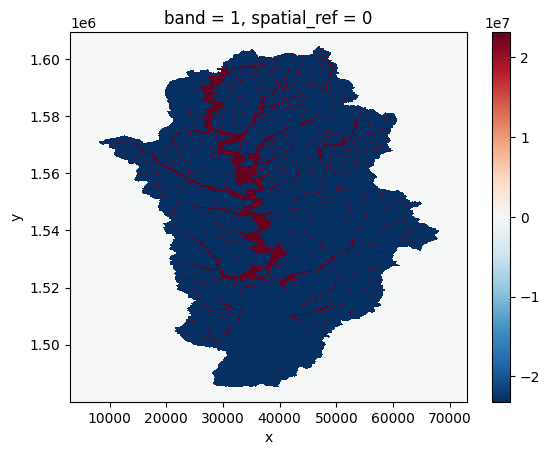

In [3]:
hand_tif.sel(band=1).plot()


## Note: there is a missing reservoir at the bottom of the extent

Next, we are going to visualize the `hmax.tif` results from SFINCS

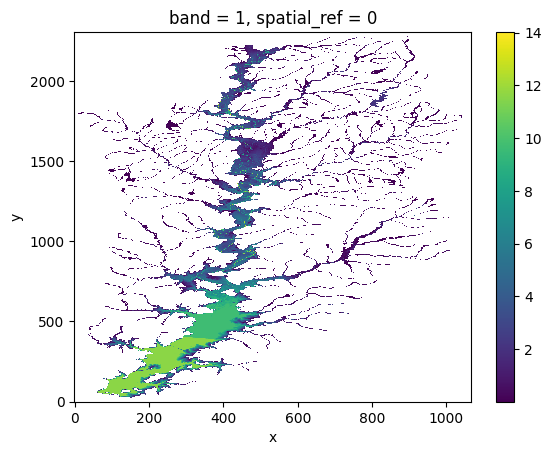

In [4]:
# sfincs_ds.sel(band=1).plot()
# First set no_data values properly (changing from 1 to 0)
formatted_sfincs_ds = sfincs_ds.sel(band=1).where(sfincs_ds.sel(band=1) != 1, 0)
formatted_sfincs_ds.plot()

These are the points associated with the storm events across Kansas, Missouri, Iowa, Nebraska, and Oklahoma from the STAC

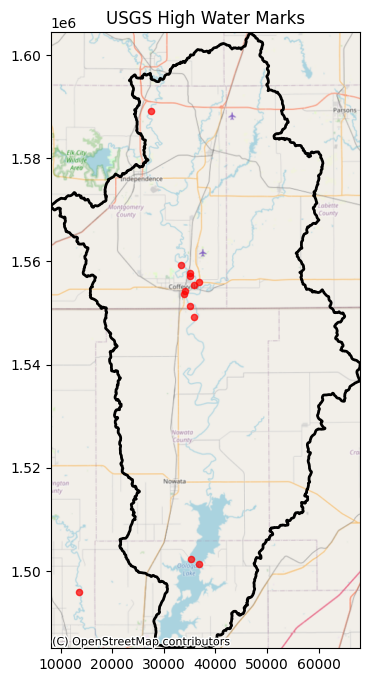

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

# Set the extent to match the huc_8 boundary
ax.set_xlim(huc_8_boundary.total_bounds[0], huc_8_boundary.total_bounds[2])
ax.set_ylim(huc_8_boundary.total_bounds[1], huc_8_boundary.total_bounds[3])

# Plot huc_8_boundary with no face color (just the outline)
huc_8_boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Plot the high water marks
usgs_hwm.plot(ax=ax, color='red', markersize=20, alpha=0.7)

# Add the basemap
cx.add_basemap(ax, crs=usgs_hwm.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

plt.title('USGS High Water Marks')
plt.show()


Lastly, here are the sentinel-2 flood extent points. The extent from this data was taken from the KARS flood image mapper tool: https://kars.geoplatform.ku.edu/pages/flooded-image-mapper and the raw image can be found at: /app/data/SFINCS/sentinel-2-raw.png

Notice how in /app/data/SFINCS/sentinel-2-raw.png there is some cloud cover in the top right of the extent which paints a false positive.

Below we will load in the extent raster and clip it to the HUC8 for plotting purposes

In [6]:
# First set no_data values properly (changing from 1 to 0)
formatted_sentinel = sentinel_data.sel(band=1).where(sentinel_data.sel(band=1) != 1, 0)

/opt/conda/lib/python3.11/site-packages/matplotlib/colors.py:1404: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


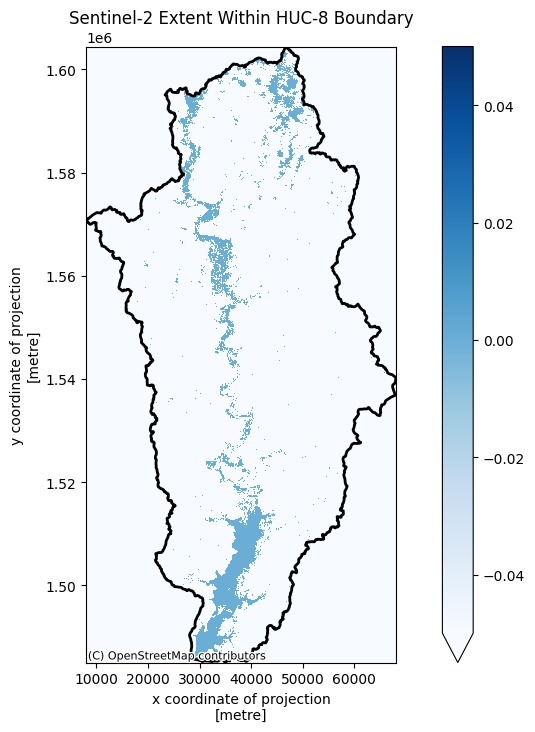

In [7]:
# Make sure the CRS of both datasets match
if formatted_sentinel.rio.crs != huc_8_boundary.crs:
    # Reproject the raster to match the vector if needed
    formatted_sentinel = formatted_sentinel.rio.reproject(huc_8_boundary.crs)

# Clip the raster to the boundary
clipped_sentinel = formatted_sentinel.rio.clip(
    huc_8_boundary.geometry, 
    huc_8_boundary.crs,
    drop=True,  # Drop geometries outside the clip area
    all_touched=True  # Include cells that are partially within the boundary
)

# Now use clipped_sentinel in your plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the extent to match the huc_8 boundary
ax.set_xlim(huc_8_boundary.total_bounds[0], huc_8_boundary.total_bounds[2])
ax.set_ylim(huc_8_boundary.total_bounds[1], huc_8_boundary.total_bounds[3])

# Plot the clipped data
clipped_sentinel.plot(
    ax=ax, 
    cmap='Blues',  # Choose appropriate colormap for flood data
    add_colorbar=True,
    vmin=0,  # Adjust based on your data values
    vmax=clipped_sentinel.max().item()  # Use actual max or a fixed value
)

huc_8_boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)


# Add the basemap
cx.add_basemap(ax, crs=huc_8_boundary.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

plt.title('Sentinel-2 Extent Within HUC-8 Boundary')
plt.show()

### Test 1: Do our FIMs contain the USGS HWM points?
For both HAND and SFINCS we are going to be drawing a bounding box around the grid that houses the FIM. From there, we are going to check where the USGS HWM points intersect based on the coordinates, then determine if the intersecting pixel is flood or no flood. From there, we will see if the FIM hit the marks. 

Note: There are more USGS HWMs in the HAND set as it's a HUC8 and covers a larger area. SFINCS, being a collection of hydrofabric catchments around the town of Coffeyville, contains 4 less HWM points. So while a quantitative test is good to see, these Metrics have to be backed by a visual analysis (See the deliverable Powerpoint)

In [8]:
def find_hand_intersection(file_path, usgs_points):
    with rasterio.open(file_path) as src:
        raster_bounds = src.bounds
        bbox = box(raster_bounds.left, raster_bounds.bottom, 
                   raster_bounds.right, raster_bounds.top)
        
        buffers_within_raster = usgs_points[usgs_points.geometry.intersects(bbox)]
        
        valid_points = 0
        for geom in buffers_within_raster.geometry:
            window = rasterio.windows.from_bounds(*geom.bounds, src.transform)
            data = src.read(1, window=window)
            if np.any((~np.isnan(data)) & (data > 0)):
                valid_points += 1
        
        print(f"Total high water marks within raster bounds: {len(buffers_within_raster)}")
        print(f"High water marks intersecting the flood domain: {valid_points}")


In [9]:
find_hand_intersection(hand_path, usgs_hwm)


Total high water marks within raster bounds: 32
High water marks intersecting the flood domain: 0


While the HWMs did not directly intersect the HAND flow lines, let's see if they do with us buffering the points

In [10]:
usgs_hwm_buffered = usgs_hwm.copy()
usgs_hwm_buffered['geometry'] = usgs_hwm.geometry.buffer(5)
find_hand_intersection(hand_path, usgs_hwm_buffered)


Total high water marks within raster bounds: 32
High water marks intersecting the flood domain: 8


In [11]:
usgs_hwm_buffered = usgs_hwm.copy()
usgs_hwm_buffered['geometry'] = usgs_hwm.geometry.buffer(10)
find_hand_intersection(hand_path, usgs_hwm_buffered)


Total high water marks within raster bounds: 32
High water marks intersecting the flood domain: 9


From this we can see 8 of the 32 points within the HUC8 were within 5m of a pixel, while 9 points were within 10m of a pixel. Now, let's try with SFINCS

In [12]:
def find_sfincs_intersection(file_path, usgs_points):
    with rasterio.open(file_path) as src:
        from shapely.geometry import box
        raster_bounds = src.bounds
        bbox = box(raster_bounds.left, raster_bounds.bottom, 
                   raster_bounds.right, raster_bounds.top)
        points_within_raster = usgs_points[usgs_points.geometry.intersects(bbox)]
        
        model_values = list(src.sample([(geom.centroid.x, geom.centroid.y) 
                                      for geom in points_within_raster.geometry]))
        
        model_values = np.array(model_values).flatten()
        valid_points = np.sum(~np.isnan(model_values))  # Only check for non-NaN values
        
        print(f"Total high water marks within raster bounds: {len(points_within_raster)}")
        print(f"High water marks intersecting the SFINCS domain: {valid_points}")


In [13]:
find_sfincs_intersection(sfincs_path, usgs_hwm)


Total high water marks within raster bounds: 29
High water marks intersecting the SFINCS domain: 10


### Comparing with Sentinel-2 Data

Next, we're going to compare our FIMs to the sentinel-2 flood extent. While Sentinel-2 is a great ground truth, it suffers from the same problem as HAND. Since HAND covers a larger area, and clipping the rasters / reprojecting can cause precision loss, our numbers can only give a metric unique to the FIM.

In [14]:
with rasterio.open(sentinel_path) as obs:
    obs_data = obs.read(1)
    
    with rasterio.open(hand_path) as src:
        hand_data = src.read(1)
        
        obs_resampled = np.zeros_like(hand_data)
        rasterio.warp.reproject(
            source=obs_data,
            destination=obs_resampled,
            src_transform=obs.transform,
            src_crs=obs.crs,
            dst_transform=src.transform,
            dst_crs=src.crs,
            resampling=rasterio.enums.Resampling.nearest
        )
        
        # Now create mask and find overlap
        hand_valid = hand_data > 0
        overlap = (obs_resampled == 1) & hand_valid
        
        print(f"\nNumber of flooded cells in resampled Sentinel: {np.sum(obs_resampled == 1)}")
        print(f"Number of overlapping flood cells: {np.sum(overlap)}")
        print(f"Percent accuracy: {np.sum(overlap)/np.sum(obs_resampled == 1)}")



Number of flooded cells in resampled Sentinel: 6182094
Number of overlapping flood cells: 1059463
Percent accuracy: 0.1713760741910427


In [15]:
with rasterio.open(sentinel_path) as obs:
    obs_data = obs.read(1)
    
    with rasterio.open(sfincs_path) as src:
        sfincs_data = src.read(1)
        
        # Reproject obs_data to match SFINCS grid
        obs_resampled = np.zeros_like(sfincs_data)
        rasterio.warp.reproject(
            source=obs_data,
            destination=obs_resampled,
            src_transform=obs.transform,
            src_crs=obs.crs,
            dst_transform=src.transform,
            dst_crs=src.crs,
            resampling=rasterio.enums.Resampling.nearest
        )
        
        # Now create mask and find overlap
        sfincs_valid = ~np.isnan(sfincs_data)
        overlap = (obs_resampled == 1) & sfincs_valid
        
        print(f"\nNumber of flooded cells in resampled Sentinel: {np.sum(obs_resampled == 1)}")
        print(f"Number of overlapping flood cells: {np.sum(overlap)}")
        print(f"Percent accuracy: {np.sum(overlap)/np.sum(obs_resampled == 1)}")



Number of flooded cells in resampled Sentinel: 171473
Number of overlapping flood cells: 109229
Percent accuracy: 0.6370040764435217


### Conclusions

While the percent accuracy of the sentinel data was higher with SFINCS, the resolution of HAND is higher than that of SFINCS. HOWEVER, there are some things to note with the comparison:
1. HAND does NOT have the reservoir at the bottom of the HUC8 (which is shown in the sentinel flood extent)
2. SFINCS is at 50m while HAND is at 10m resolution
3. SFINCS does not take in lateral inflows, leading to potential underestimation